In [ ]:
!git clone https://github.com/Ro6ertWcislo/AutoESN.git

In [ ]:
!unzip /content/drive/MyDrive/pjm.zip

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose
import optuna
import torch
from matplotlib import pyplot as plt
import numpy as np

import auto_esn.utils.dataset_loader as dl
from auto_esn.datasets.df import MackeyGlass
from auto_esn.esn.esn import GroupedDeepESN
from auto_esn.esn.reservoir.activation import self_normalizing_default
from auto_esn.esn.reservoir.util import NRMSELoss
from auto_esn.esn.reservoir.initialization import CompositeInitializer, WeightInitializer
from auto_esn.esn.reservoir.util import NRMSELoss

nrmse = NRMSELoss()

### Electricity Dataset

four datasets - electricity, temperatur, [hungarian chickenpox](https://archive.ics.uci.edu/dataset/580/hungarian+chickenpox+cases), my own data



In [ ]:
electricity = pd.read_csv('PJME_hourly.csv')

In [ ]:
electricity.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
electricity.columns

Index(['Datetime', 'PJME_MW'], dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_electricity(electricity_df):
    electricity_df.rename(columns = {'Datetime':'date'}, inplace = True)
    electricity_df.drop_duplicates(subset = 'date')
    electricity_df['y'] = electricity_df.groupby('date')['PJME_MW'].transform('sum')
    electricity_df['date'] = pd.to_datetime(electricity_df["date"])
    electricity_df.drop_duplicates(subset = ['date'],inplace=True)
    # el.drop(columns = ['date', 'time'], inplace = True)
    electricity_df.set_index('date', inplace = True)
    electricity_df = electricity_df[electricity_df.index.year>2010]
    el_train = electricity_df[electricity_df.index.year<2017]
    el_val = electricity_df[electricity_df.index.year>=2017]

    columns_to_normalize = electricity_df.columns
    scaler = MinMaxScaler()
    el_train[columns_to_normalize] = scaler.fit_transform(el_train[columns_to_normalize].values)
    el_val[columns_to_normalize] = scaler.transform(el_val[columns_to_normalize.values])

    return el_train, el_val, electricity_df

In [ ]:
el_train, el_val, electricity = prepare_electricity(electricity)

<ipython-input-9-7442b227a0f2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_train[columns_to_normalize] = scaler.fit_transform(el_train[columns_to_normalize].values)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
<ipython-input-9-7442b227a0f2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  el_val[columns_to_normalize] = scaler.transform(el_val[columns_to_normalize.values])


In [ ]:
def data_to_torch(data):
    a = np.array(data)
    return torch.from_numpy(a)

In [ ]:
train_X, train_y = data_to_torch(el_train['y'].values[:-1]), data_to_torch(el_train['y'].values[1:])

In [ ]:
test_X, test_y = data_to_torch(el_val['y'].values[:-1]), data_to_torch(el_val['y'].values[1:])

### esn definition

In [ ]:
def best_deepesn_initializer(seed):
    # initialize input weights with uniform distribution from -1 to 1 and specified seed to reproduce results
    input_weight = CompositeInitializer().with_seed(seed).uniform()

    reservoir_weight = CompositeInitializer() \
        .with_seed(seed) \
        .uniform() \
        .sparse(density=0.1) \
        .spectral_normalize() \
        .scale(factor=1.0)  # unnecesary but i wanted to make it explicit

    return WeightInitializer(weight_ih_init=input_weight, weight_hh_init=reservoir_weight)

In [ ]:
X, X_test, y, y_test = train_X, test_X, train_y, test_y

X = torch.reshape(X, (X.shape[0],1))
y = torch.reshape(y, (y.shape[0],1))

X_test = torch.reshape(X_test, (X_test.shape[0],1))
y_test = torch.reshape(y_test, (y_test.shape[0],1))

activation = self_normalizing_default(leaky_rate=1, spectral_radius=120)
seed = 70

### One step ahead prediction

In [ ]:
def get_activation(leaky_rate = 1, radius = 120):
    return self_normalizing_default(leaky_rate=leaky_rate, spectral_radius=radius)

In [ ]:
def get_esn(activation, input_size = 6, groups = 3, groups_def = (2,2,2), hidden_size =100, seed = 70):
    esn = GroupedDeepESN(
        input_size=input_size,
        groups=groups,
        num_layers=groups_def,
        hidden_size=hidden_size,
        initializer=best_deepesn_initializer(seed),
        activation=activation
    )
    return esn

In [ ]:
esn = get_esn(get_activation(), input_size = 1)

In [ ]:
esn.fit(X, y)

### Optuna study

In [ ]:
def objective(trial):
    activation = get_activation(
        leaky_rate = trial.suggest_float("leaky_rate", 0.85, 1.2),
        radius = trial.suggest_int("spectral radius", 100,800))
    esn = get_esn(activation, input_size = 1,hidden_size = trial.suggest_int("hidden_size",100,550))
    esn.fit(X, y)
    output = esn(X_test)
    return nrmse(output, y_test).item()

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

[I 2024-01-17 07:54:52,683] A new study created in memory with name: no-name-08b46e02-7561-4498-b0f2-35a018dbb0e5
[I 2024-01-17 07:56:54,513] Trial 0 finished with value: 0.14294817580858402 and parameters: {'leaky_rate': 0.8855591791996212, 'spectral radius': 715, 'hidden_size': 217}. Best is trial 0 with value: 0.14294817580858402.


In [ ]:
study.best_params

{'leaky_rate': 0.8855591791996212, 'spectral radius': 715, 'hidden_size': 217}

#visualize one step ahead prediction

In [ ]:
esn = get_esn(get_activation(leaky_rate = study.best_params['leaky_rate'],
                             radius = study.best_params['spectral radius']),
              hidden_size = study.best_params['hidden_size'], input_size = 1)
esn.fit(X, y)

In [ ]:
X_test.shape, y_test.shape

(torch.Size([13894, 1]), torch.Size([13894, 1]))

value of nrmse metric:  0.2113523685133843


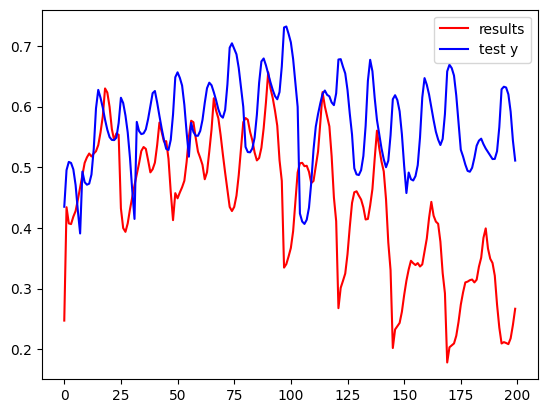

In [ ]:
output = esn(X_test[:200])
# evaluate
n = nrmse(output, y_test[:200]).item()
print('value of nrmse metric: ',n)
# plot
last = 200
plt.plot(range(last), output.view(-1).detach().numpy()[-last:], 'r', label = 'results')
plt.plot(range(last), y_test.view(-1).detach().numpy()[-last:], 'b', label = 'test y')
leg = plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

print('values for one step ahead prediction')
print('nrmse : ',n)
print('mse : ', mean_squared_error(output, y_test[:200]))
print('mape : ', mean_absolute_percentage_error(output, y_test[:200]))

values for one step ahead prediction
nrmse :  0.2113523685133843
mse :  0.0005711914726715433
mape :  0.032748030715084975


### Extrapolation multistep ahead prediction


In [ ]:
steps_ahead = 24

In [ ]:
train_X.shape, train_y.shape

(torch.Size([52598]), torch.Size([52598]))

In [ ]:
X, X_test, y, y_test = train_X, test_X, train_y, test_y

X = torch.reshape(X, (X.shape[0],1))
y = torch.reshape(y, (y.shape[0],1))

X_test = torch.reshape(X_test, (X_test.shape[0],1))
y_test = torch.reshape(y_test, (y_test.shape[0],1))

activation = self_normalizing_default(leaky_rate=1, spectral_radius=120)
seed = 70

In [ ]:
def objective(trial):
    activation = get_activation(
        leaky_rate = trial.suggest_float("leaky_rate", 0.85, 1.2),
        radius = trial.suggest_int("spectral radius", 100,800))
    esn = get_esn(activation, input_size = 1,hidden_size = trial.suggest_int("hidden_size",100,550))
    esn.fit(X, y)
    output = esn(X_test)
    return nrmse(output, y_test).item()

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

[I 2024-01-17 08:00:46,153] A new study created in memory with name: no-name-e388b06a-13e1-4bcf-beba-d2d4dc4272b4
[I 2024-01-17 08:06:48,492] Trial 0 finished with value: 0.133034874510942 and parameters: {'leaky_rate': 0.9925308907093838, 'spectral radius': 207, 'hidden_size': 520}. Best is trial 0 with value: 0.133034874510942.


In [ ]:
esn = get_esn(get_activation(leaky_rate = study.best_params['leaky_rate'],
                             radius = study.best_params['spectral radius']),
              hidden_size = study.best_params['hidden_size'], input_size = 2)

In [ ]:
esn.fit(X, y)

RuntimeError: input has inconsistent input_size: got 1, expected 2

In [ ]:
extrapolation_steps = steps_ahead
val = X_test[0:1]
result = []
for j in range(extrapolation_steps):  # 100 steps ahead
    val = esn(val)  # (1,1) tensor
    result.append(val)

res = torch.vstack(result)
# evaluate
err = nrmse(res, y_test[:extrapolation_steps]).item()
print(f"Extrapolation error: {err}")

# plot validation set

# plot
last = 200
# we have 2dimensional input, so we have to plot two series for ground truth and for prediction
# plot original prediction
plt.plot(range(extrapolation_steps), res[:, 0].view(-1).detach().numpy()[-last:], 'r', label = 'result')
# plot shifted prediction
plt.plot(range(extrapolation_steps), res[:, 0].view(-1).detach().numpy()[-last:], 'r',  label = 'result')
# plot original ground truth
plt.plot(range(extrapolation_steps), y_test[:extrapolation_steps, 0].view(-1).detach().numpy()[-last:], 'b', label = 'target')
# plot shifted ground truth
plt.plot(range(extrapolation_steps), y_test[:extrapolation_steps, 0].view(-1).detach().numpy()[-last:], 'b', label = 'target')
plt.legend()
plt.show()

print('values for multi step ahead prediction')
print('nrmse : ',err)
print('mse : ', mean_squared_error(res, y_test[:extrapolation_steps]))
print('mape : ', mean_absolute_percentage_error(res, y_test[:extrapolation_steps]))